In [1]:
# Necessary dependencies for this Notebook:
# Needs tequila version>1.7.0
# e.g. pip install --upgrade git+https://github.com/aspuru-guzik-group/tequila.git@devel
# PySCF: pip install pyscf
# Recommended: pip install qulacs
import tequila as tq
import numpy
import time

# convenience to avoid "tq.gates" in circuit construction
from tequila.circuit.gates import X, CNOT, Ry, QubitExcitation

# Molecular Quantum Circuit Design: A Graph Based Approach

<img src="pics/overview_cartoon.png" width=400/>

- This notebook showcases the results of the article with the same title.  
- You can find the original article [here](https://arxiv.org/abs/2207.12421).  

- If you are using this for your research, considering citing dependencies as well (see the "Computational Details & Code Availability" section of the article).




## Two-Electron Systems

We will start by creating a function that generates a general version of the circuit displayed in Eq.(11) in the paper

<img src="pics/electron_pair_circuit.png" width=400/>

it generates a wavefunction for a spin-restriced electron-pair in $R_\text{e}$ spatial orbitals. Spin-restriction in this context means, that electrons are always forced to form spin pairs. They move as quasi-particles sometimes referred to as *hardcore Bosons* - (see for example Section I.A. of [arxiv/2105.03836](https://arxiv.org/pdf/2105.03836.pdf)).  

The $N$-qubit wavefunction looks like
$$
U_2^N \lvert 0\dots0 \rangle = \sum_{k=0}^{R_\text{e}-1} \cos\left(\frac{\theta_k}{2}\right)\prod_{l=0}^{k-1}\left(\sin\left(\frac{\theta_l}{2}\right)\right)\lvert2^{2k+1}+2^{2k}\rangle\nonumber = c_0 \lvert 1100\dots0 \rangle + c_1 \lvert 0011\dots0 \rangle + \dots
$$
with $N=2R_\text{e}$

In [4]:
def make_Upair(qubits: list, label=None):
    # need even number of qubits
    assert len(qubits) % 2 == 0
    U = X(qubits[0])
    c = None
    for q in range(len(qubits)//2-1):
        angle = (q,q+1,label)
        U+= Ry(angle,qubits[2*q+2],control=c)
        U+= CNOT(qubits[2*q+2], qubits[2*q])
        c = 2*q+2
    # the CNOT sequence that transforms from Hardcore Boson to Jordan-Wigner
    U += sum([CNOT(qubits[2*q],qubits[2*q+1]) for q in range(len(qubits)//2)], tq.QCircuit())
    return U

Let's run this circuit for some angles and see how the wavefunction looks. It should look like described above:

In [3]:
U = make_Upair(qubits=[0,1,2,3,4,5,6,7])
variables = {k:1.0 for k in U.extract_variables()}
wfn = tq.simulate(U, variables)
print(wfn)

+0.8776|11000000> +0.4207|00110000> +0.2017|00001100> +0.1102|00000011> 


Let's reproduce the left plot in Fig.2 of the paper where this particular circuit is tried out for Hydrogen-Molecules in an 6-31G basis. First we will create the molecule with tequila and then compute two VQEs, one with the standard Hartree-Fock orbitals and one with optimized orbitals for this circuit - note that the optimized orbitals are still in the same basis set, we are just optimizing the orbital representation within the given 6-31G basis.  

In [4]:
# loop over bond distances
# feel free to reduce points for faster runtime
# 10 points should take about 400s (reference: Dell XPS from 2019 ,intel i5, 4 threads)
# Time consuming part: orbital-optimization (evaluation of density matrices, takes a few iterations since no clever guess is used here)
npoints=10
geom = "H 0.0 0.0 0.0\nH 0.0 0.0 {}"
start = time.time()
# collecting data
spa_hf=[]
spa_opt=[]
exact = []
x = []

guess = None
for R in numpy.linspace(0.5, 3.0, npoints):
    mol = tq.Molecule(geometry=geom.format(R), basis_set="6-31G")
    # no orbital optimization
    H = mol.make_hamiltonian()
    E = tq.ExpectationValue(H=H, U=U)
    result = tq.minimize(E, silent=True)
    delta=1.0
    energy = result.energy
    # orbital optimization
    while(delta > 1.e-4):
        opt = tq.chemistry.optimize_orbitals(circuit=U, molecule=mol, silent=True, initial_guess=guess)
        guess = opt.mo_coeff
        delta=abs(opt.energy-energy)
        energy = opt.energy
    # save data
    spa_hf.append(result.energy)
    spa_opt.append(opt.energy)
    exact.append(mol.compute_energy("fci"))
    x.append(R)
end = time.time()
print("runtime: {}s".format(end-start))

converged SCF energy = -1.05802481296927
converged SCF energy = -1.12530860416883
converged SCF energy = -1.08435007825667
converged SCF energy = -1.02926301467656
converged SCF energy = -0.977519224346808
converged SCF energy = -0.932367146464438
converged SCF energy = -0.894183762983294
converged SCF energy = -0.862514623706141
converged SCF energy = -0.836584370668952
converged SCF energy = -0.815591772270656
runtime: 401.4002389907837s


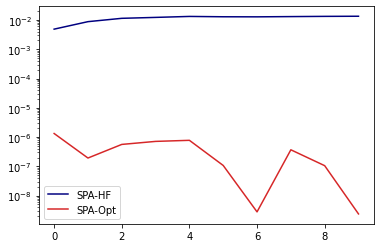

In [5]:
# this is just the plotting
import matplotlib.pyplot as plt
Re = len(x)
plt.plot([spa_hf[i]-exact[i] for i in range(Re)], color="navy", label="SPA-HF")
plt.plot([spa_opt[i]-exact[i] for i in range(Re)], color="tab:red", label="SPA-Opt")
plt.yscale("log")
plt.legend()
plt.show()

Looks like in the paper.  
The red line might vary (as internal optimization thresholds change in tequila an pyscf and below 1.e-4 doesn't really matter anymore)

## Graph-SPA

Now that we have seen the two-electron circuit at work we will construct a four electron circuit for H4/STO-3G(4,8) from it as described in the paper.  
We start by initializing the molecule in a basis of orthonormalized STO-3G orbitals - this can be achieved over the `orthonormalize_basis_orbitals` function of a tequila molecule.

In [2]:
geom = "H 0.0 0.0 0.0\nH 0.0 0.0 1.5\nH 0.0 0.0 3.0\nH 0.0 0.0 4.5"
mol = tq.Molecule(geometry=geom, basis_set="STO-3G")
mol = mol.orthonormalize_basis_orbitals()
fci = mol.compute_energy("fci")

converged SCF energy = -1.82913741235697


As an initial guess for the optimal basis function we will try to mimic the molecular graph

<img src="pics/h4_graph_1.png" width=200/>

this means we are creating the following linear combination out of our atomic orbitals as guess orbitals

<img src="pics/h4_orbital_guess.png" width=150/>

where blue and red dots represent positive and negative superpositions of STO-3G S-Orbitals.



In [5]:
# if we use the same labels, we use the same variables
# that means we are exploiting symmetry (which is fine in this example)
USPA = make_Upair(qubits=[0,1,2,3],label=0)
USPA+= make_Upair(qubits=[4,5,6,7],label=0)

delta = 1.0
energy = 1.0
guess = numpy.zeros(shape=[mol.n_orbitals, mol.n_orbitals])
guess[0] = [1.0, 1.0,0.0,0.0]
guess[1] = [1.0,-1.0,0.0,0.0]
guess[2] = [0.0,0.0,1.0, 1.0]
guess[3] = [0.0,0.0,1.0,-1.0]
# more convenient to initialize guess in transposed form
guess = guess.T
start = time.time()
while(delta > 1.e-4):
    opt = tq.chemistry.optimize_orbitals(circuit=USPA, molecule=mol, silent=True, initial_guess=guess)
    guess = opt.mo_coeff
    delta=abs(opt.energy-energy)
    energy = opt.energy
stop = time.time()

# make the optimized molecule the molecule
mol = opt.molecule

print("finished H4-Graph-SPA in {:4.1f}s".format(stop-start))
print("Graph-SPA Energy : {:+2.5f}".format(energy))
print("Graph-SPA Error  : {:+2.5f}".format(fci-energy))

finished H4-Graph-SPA in 30.4s
Graph-SPA Energy : -1.97989
Graph-SPA Error  : -0.01626


We can now look at the optimized orbital coefficients and compare to our initial guess

In [6]:
mol.print_basis_info()

basis_type      : custom
basis_name      : STO-3G
orthogonal      : True
functions       : 4
reference       : [0, 1]
Current Orbitals
{idx_total:0, idx:0}
coefficients:  [ 0.7043653   0.70026191  0.08240649 -0.08192642]
{idx_total:1, idx:1}
coefficients:  [ 0.70026191 -0.7043653   0.08192642  0.08240649]
{idx_total:2, idx:2}
coefficients:  [-0.08192642  0.08240649  0.70026191  0.7043653 ]
{idx_total:3, idx:3}
coefficients:  [-0.08240649 -0.08192642  0.7043653  -0.70026191]


As in the paper, we see that they represent a slightly more delocalized picture
<img src="pics/h4_orbital_result.png" width=150/>

## Multi-Graph Circuit

We will now extend the SPA circuit from the section before with another molecular graph, the one that resembles a central H-H bond:

<img src="pics/h4_graph_2.png" width=200/>

the initial guess for the corresponding orbitals is

<img src="pics/h4_orbitals_2.png" width=150/>

as we are rotating from the optimized SPA orbitals to this frame and back we can't optimize the orbitals as before, but rather have to represent the orbital rotation by unitary circuits. The image on the top of this notebook illustrates that process.   
For H4, we chose the same strategy as in the paper and first rotate back to the local frame before we rotate to the central bond picture.

In [7]:
R0 = tq.Variable("R0")
R1 = tq.Variable("R1")
pi = numpy.pi
# rotate back to localized frame
UR0 = mol.make_excitation_gate(angle=(R0+0.5)*pi, indices=[(0,2)])
UR0+= mol.make_excitation_gate(angle=(R0+0.5)*pi, indices=[(1,3)])
UR0+= mol.make_excitation_gate(angle=(R0+0.5)*pi, indices=[(4,6)])
UR0+= mol.make_excitation_gate(angle=(R0+0.5)*pi, indices=[(5,7)])
# form the central bond
UR1 = mol.make_excitation_gate(angle=(R1+0.5)*pi, indices=[(2,4)])
UR1+= mol.make_excitation_gate(angle=(R1+0.5)*pi, indices=[(3,5)])

# add electron-pair correlator to the central bond - see Eq.(22) in the paper.
UC = tq.gates.QubitExcitation(target=[2,4,3,5], angle="C")

# construct the circuit for both graphs
U = USPA + UR0 + UR1 + UC + UR1.dagger() + UR0.dagger()

# construct and optimize the expectation value
H = mol.make_hamiltonian()
E = tq.ExpectationValue(H=H, U=U)
start = time.time()
result_multi = tq.minimize(E, silent=True)
stop = time.time()

print("finished H4-Graph-SPA in {:4.1f}s".format(stop-start))
print("Multi-Graph Energy : {:+2.5f}".format(result_multi.energy))
print("Multi-Graph Error  : {:+2.5f}".format(fci-result_multi.energy))

finished H4-Graph-SPA in  3.9s
Multi-Graph Energy : -1.98771
Multi-Graph Error  : -0.00844


We observe the same results as described in the paper!  

Finally we demonstrate an additional orbital optimization round, this time with the Multi-Graph circuir instead of the SPA circuit. This will show, that there is no further improvement. Good news, as the orbital optimization is much cheaper when performend with the classically tractable SPA circuit!

In [8]:
start = time.time()
U = USPA + UR0 + UR1 + UC + UR1.dagger() + UR0.dagger()
energy=1.0
delta=1.0
guess=None
while(delta > 1.e-4):
    opt = tq.chemistry.optimize_orbitals(circuit=U, molecule=mol, silent=True, initial_guess=guess)
    guess = opt.mo_coeff
    delta=abs(opt.energy-energy)
    energy = opt.energy
stop = time.time()
print(fci-energy)

-0.008127148704816012


## Bonus

Unsure if an SPA pair is really classically tractable? Here is a simulation with up to 1024 qubits. Note that you need to use the symbolic simulator of tequila (usually not recommended since it is the by-far slowest). The reason being that this simulator is not allocating memory for 2^1024 complex numbers (what qulacs is for example doing) but creating the wavefunction one gate after another. You could do an expectation value as well, however, computing the Hamiltonian and evaluating the individual Pauli expectationvalues is not optimized for this simulator, so we wouldn't recommend. Would also go not too large with the symbolic simulator as it operates on python strings and uses a horrible integer-to-binary-number converter (better not go over 500 qubit).

In [9]:
def run(biggest=512, silent=False):
    Nq = 2
    times = []
    gates = []
    while(Nq <= biggest):
        Ubig = make_Upair(qubits=list(range(Nq)))
        gates.append(len(Ubig.gates))
        variables = {k:1.0 for k in Ubig.extract_variables()}

        start = time.time()
        wfn = tq.simulate(Ubig, variables=variables, backend="symbolic")
        stop=time.time()
        if not silent: print("simulated {:4} qubits SPA with {:4} gates in {:4.2f}s".format(Nq, gates[-1], stop-start))
        Nq *= 2
        times.append(stop-start)
    return times, gates

times, gates = run()

simulated    2 qubits SPA with    2 gates in 0.00s
simulated    4 qubits SPA with    5 gates in 0.01s
simulated    8 qubits SPA with   11 gates in 0.01s
simulated   16 qubits SPA with   23 gates in 0.02s
simulated   32 qubits SPA with   47 gates in 0.05s
simulated   64 qubits SPA with   95 gates in 0.17s
simulated  128 qubits SPA with  191 gates in 0.89s
simulated  256 qubits SPA with  383 gates in 5.43s
simulated  512 qubits SPA with  767 gates in 39.67s


doesn't look like there are serious memory troubles. However: Don't take data from the tequila symbolic backend as serious benchmark, the simulator is not very good and only intended for debug purposes :-).

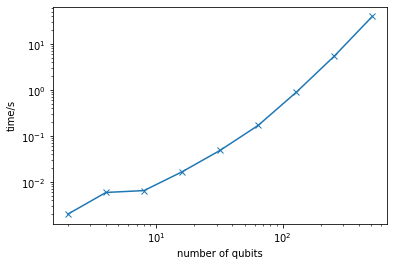

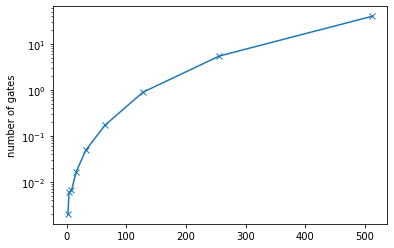

In [10]:
from matplotlib import pyplot as plt
plt.figure()
qubits = [2**(i+1) for i in range(len(times))]
plt.xlabel("number of qubits")
plt.ylabel("time/s")
plt.yscale("log")
plt.xscale("log")
plt.plot(qubits,times, marker="x")
plt.show()
plt.ylabel("number of gates")
plt.yscale("log")
plt.plot(qubits,times, marker="x")
plt.show()